## Scenario II - All NLP cleaning steps

#### Split the dataset into training and test and then vectorizing first using tf-idf and then count vectorization

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from gensim.parsing.preprocessing import remove_stopwords
import re
# from autocorrect import Speller
from tqdm.notebook import tqdm
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
import unidecode

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\camil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
## Import the file cleaned on the previous step 

df = pd.read_csv('new_base_clean', index_col=0)

In [3]:
## Create a new column with only text and dropp the other columns from df dataset
## Create a new variable only with the label

X = df.text
y = df.label

#### NLP preprocessing steps

In [4]:
## Adjust the text to ASCII format, remove stopwords, url, html, special charcters and transform the letters to lower case

def remove_html_tags(text):
        unicode = unidecode.unidecode(text)
        stop = remove_stopwords(unicode)
        twitter = re.sub(pattern=r'@[A-Za-z0-9]+',repl=' ', string=stop)
        html = re.sub(pattern=r'<.*?>', repl=' ', string=twitter)
        urls = re.sub(pattern=r'https?://\S+|www\.\S+', repl=' ', string=html)
        special_ch = re.sub(pattern='[^a-zA-Z]',repl=' ',string=urls)
        special_cha= re.sub(pattern='\[[^]]*\]', repl=' ', string=special_ch)
        lower = special_cha.lower()
        return lower 

In [ ]:
%%time
for i in tqdm(range(100)): X = X.apply(remove_html_tags)

In [6]:
## The spelling correction step was not applied because of the time nedded

#spell_corrector = Speller(lang='en')
# for i in tqdm(range(100)): X = X.apply(spell_corrector)
# X.to_csv('X')

In [ ]:
## Tokenize the sentences

%%time
X = X.apply(lambda x: word_tokenize(x))

In [8]:
## Transform the words into their lemmas

%%time
def lemmatization(tokens):
        lemma = WordNetLemmatizer()
        for index in range(len(tokens)):
            lemma_word = lemma.lemmatize(tokens[index])
            tokens[index] = lemma_word
        return ' '.join(tokens)

X = X.apply(lemmatization)

Wall time: 38 s


#### Splitting the dataset and vectorizing the text

In [9]:
## Split the training and test dataset using 30% for test and 70% for training. 
## The random state is the seed that will be used for all the scenarios

X_train, X_test, y_train, y_test = train_test_split(  
    X, y,
    test_size= 0.30,
    random_state= 50)

In [10]:
## fit and applies the tf-idf vectorization to the train and test dataset  

tfidf = TfidfVectorizer(lowercase=False)
tfidf_train = tfidf.fit_transform(X_train)
tfidf_test = tfidf.transform(X_test)

In [11]:
## fit and applies count vectorization to the train and test dataset  

count_vectorizer =  CountVectorizer(lowercase=False)
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)

#### Training the Algorithm

In [12]:
from sklearn.naive_bayes import MultinomialNB

In [13]:
## Fits and train the NB algorithm with the tfidf vectorized training dataset
## Apply the algorithm to the tfidf test dataset

nb_tfidf = MultinomialNB()
nb_tfidf.fit(tfidf_train, y_train)
pred_tfidf = nb_tfidf.predict(tfidf_test)

In [14]:
## Fits and train the NB algorithm with the count vectorized training dataset
## Apply the algorithm to the count test dataset

nb_count = MultinomialNB()
nb_count.fit(count_train, y_train)
pred_count = nb_count.predict(count_test)

#### Models evaluation

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from matplotlib import pyplot as plt


In [16]:
print('Accuracy tfidf: ', metrics.accuracy_score(y_test, pred_tfidf))
print('Accuracy count: ', metrics.accuracy_score(y_test, pred_count))

Accuracy tfidf:  0.9279816034284519
Accuracy count:  0.9414654541653601


Text(0.5, 0.98, 'Confusion Matrix')

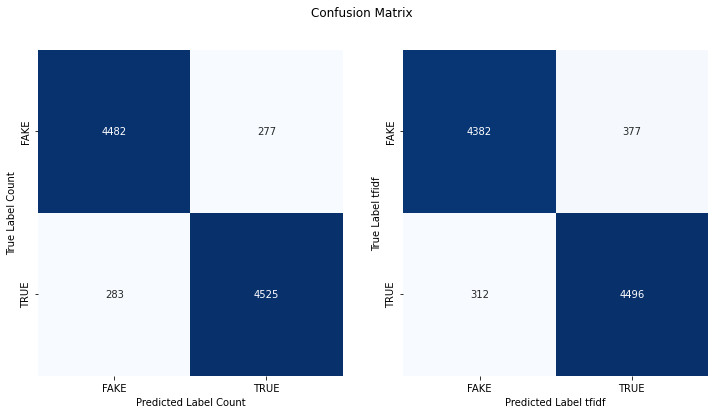

In [155]:
cm_count = confusion_matrix(y_test, pred_count)
cm_tfidf = confusion_matrix(y_test, pred_tfidf)

fig, ax =plt.subplots(1,2,figsize=(12,6))

sns.heatmap(cm_count, annot=True, fmt='d', xticklabels=['FAKE', 'TRUE'], yticklabels=['FAKE', 'TRUE'], cmap=plt.cm.Blues, cbar=False, ax=ax[0])
ax[0].set_xlabel('Predicted Label Count')
ax[0].set_ylabel('True Label Count')

sns.heatmap(cm_tfidf, annot=True, fmt='d', xticklabels=['FAKE', 'TRUE'], yticklabels=['FAKE', 'TRUE'], cmap=plt.cm.Blues, cbar=False, ax=ax[1])
ax[1].set_xlabel('Predicted Label tfidf')
ax[1].set_ylabel('True Label tfidf')


fig.suptitle('Confusion Matrix')

#### K-fold

In [23]:
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score

In [24]:
X_kfold_tfidf = tfidf.transform(df.text)

In [25]:
X_kfold_count = count_vectorizer.transform(df.text)

In [26]:
kfold_5_tfidf = cross_val_score(nb_tfidf , X_kfold_tfidf, y, cv = 5)
kfold_10_tfidf = cross_val_score(nb_tfidf , X_kfold_tfidf, y, cv = 10)
kfold_5_count = cross_val_score(nb_count , X_kfold_count, y, cv = 5)
kfold_10_count = cross_val_score(nb_count , X_kfold_count, y, cv = 10)

In [27]:
print("Avg accuracy kfold 5 tfidf: {}".format(kfold_5_tfidf.mean()))
print("Avg accuracy kfold 10 tfidf: {}".format(kfold_10_tfidf.mean()))
print("Avg accuracy kfold 5 Count: {}".format(kfold_5_count.mean()))
print("Avg accuracy kfold 10 Count: {}".format(kfold_10_count.mean()))

Avg accuracy kfold 5 tfidf: 0.9035120727500784
Avg accuracy kfold 10 tfidf: 0.908403888366259
Avg accuracy kfold 5 Count: 0.9125117591721542
Avg accuracy kfold 10 Count: 0.9173722169959235


In [144]:
tfidf_10_pred = cross_val_predict(nb_tfidf , X_kfold_tfidf, y, cv = 10)
count_10_pred = cross_val_predict(nb_count , X_kfold_count, y, cv = 10)
tfidf_5_pred = cross_val_predict(nb_tfidf , X_kfold_tfidf, y, cv = 5)
count_5_pred = cross_val_predict(nb_count , X_kfold_count, y, cv = 5)

conf_mat_tfidf_10 = confusion_matrix(y, tfidf_10_pred)
conf_mat_count_10 = confusion_matrix(y, count_10_pred)
conf_mat_tfidf_5 = confusion_matrix(y, tfidf_5_pred)
conf_mat_count_5 = confusion_matrix(y, count_5_pred)

Text(0.5, 0.98, 'Confusion Matrix')

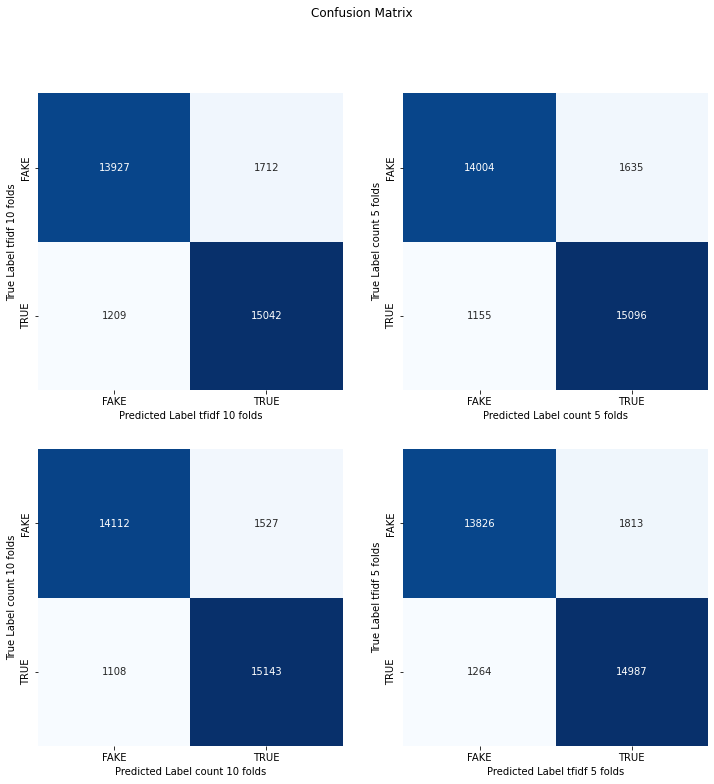

In [153]:
cm_count = confusion_matrix(y_test, pred_count)
cm_tfidf = confusion_matrix(y_test, pred_tfidf)

fig, ax = plt.subplots(2, 2,figsize=(12,12))

sns.heatmap(conf_mat_tfidf_10, annot=True, fmt='d', xticklabels=['FAKE', 'TRUE'], yticklabels=['FAKE', 'TRUE'], cmap=plt.cm.Blues, cbar=False, ax=ax[0,0])
ax[0,0].set_xlabel('Predicted Label tfidf 10 folds')
ax[0,0].set_ylabel('True Label tfidf 10 folds')

sns.heatmap(conf_mat_count_10, annot=True, fmt='d', xticklabels=['FAKE', 'TRUE'], yticklabels=['FAKE', 'TRUE'], cmap=plt.cm.Blues, cbar=False, ax=ax[1,0])
ax[1,0].set_xlabel('Predicted Label count 10 folds')
ax[1,0].set_ylabel('True Label count 10 folds')

sns.heatmap(conf_mat_tfidf_5, annot=True, fmt='d', xticklabels=['FAKE', 'TRUE'], yticklabels=['FAKE', 'TRUE'], cmap=plt.cm.Blues, cbar=False, ax=ax[1,1])
ax[1,1].set_xlabel('Predicted Label tfidf 5 folds')
ax[1,1].set_ylabel('True Label tfidf 5 folds')

sns.heatmap(conf_mat_count_5, annot=True, fmt='d', xticklabels=['FAKE', 'TRUE'], yticklabels=['FAKE', 'TRUE'], cmap=plt.cm.Blues, cbar=False, ax=ax[0,1])
ax[0,1].set_xlabel('Predicted Label count 5 folds')
ax[0,1].set_ylabel('True Label count 5 folds')


fig.suptitle('Confusion Matrix')